 build a classification model to predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
df_adm = pd.read_csv('ADMISSIONS.csv.gz')
#!pip install seaborn
import seaborn as sns
#!pip install scikit-learn

In [ ]:
df_adm.info()


In [ ]:
df_adm.head(100)


In [4]:
df_adm2 = df_adm[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE']]

In [5]:
df_adm2.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY


In [ ]:
# convert the dates from their string format into a datetime.
df_adm2.ADMITTIME = pd.to_datetime( df_adm2.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')

df_adm2.DISCHTIME = pd.to_datetime( df_adm2.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')

df_adm2.DEATHTIME = pd.to_datetime( df_adm2.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')

In [7]:
df_adm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SUBJECT_ID      58976 non-null  int64         
 1   HADM_ID         58976 non-null  int64         
 2   ADMITTIME       58976 non-null  datetime64[ns]
 3   DISCHTIME       58976 non-null  datetime64[ns]
 4   DEATHTIME       5854 non-null   datetime64[ns]
 5   ADMISSION_TYPE  58976 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 2.7+ MB


In [8]:
df_adm2 = df_adm2.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm2 = df_adm2.reset_index(drop = True)

In [ ]:
pd.options.display.max_rows = 200
df_adm2.head(200)


It is worth observing that SUBJECT_ID==109 has been admitted a total of 34 times between the dates 2137-11-04 and 2142-08-28.

In [10]:
# we add 2 new column. 
df_adm2['NEXT_ADMITTIME'] = df_adm2.groupby("SUBJECT_ID").ADMITTIME.shift(-1)

df_adm2['NEXT_ADMISSION_TYPE'] = df_adm2.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
df_adm2.head(20)
# For each admission, we can observe the time and type of any subsequent admission, if applicable.


#Subject_ID 36 serves as an excellent illustration of having experienced two consecutive admissions,
#with the final one being elective.
df_adm2.loc[ [35,36,37,38] , :]




,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
35,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,EMERGENCY,2131-05-12 19:49:00,EMERGENCY
36,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,2134-05-10 11:30:00,ELECTIVE
37,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,NaT,ELECTIVE,NaT,NaN
38,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaT,EMERGENCY,NaT,NaN


But, we want to predict UNPLANNED re-admissions, so we should filter out the ELECTIVE next admissions.

In [70]:
# get rows where next admission is elective
Rows_next_elective = df_adm2.NEXT_ADMISSION_TYPE == 'ELECTIVE'

#next admission time and type replaced by(NaT, NaN) in rows with elective admission
df_adm2.loc[Rows_next_elective,'NEXT_ADMITTIME'] = pd.NaT
df_adm2.loc[Rows_next_elective,'NEXT_ADMISSION_TYPE'] = np.NaN

df_adm2.loc[ [35,36,37,38] , :]
# we can observe the changes in SUBJECT_ID==36

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
35,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,EMERGENCY,2131-05-12 19:49:00,EMERGENCY
36,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,NaT,NaN
37,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,NaT,ELECTIVE,NaT,NaN
38,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaT,EMERGENCY,NaT,NaN


In [71]:
#sort by subject_ID and admission date
# it is safer to sort right before the fill in case something changed the order above

df_adm2 = df_adm2.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill (this will take a little while)
df_adm2[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm2.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')


Next step = calculate the days until the next admission

In [22]:

df_adm2['DAYS_NEXT_ADMIT'] = (df_adm2.NEXT_ADMITTIME - df_adm2.DISCHTIME).dt.total_seconds()/(24*60*60)
df_adm2.loc[ [35,36,37,38] , :]


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
35,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaT,EMERGENCY,2131-05-12 19:49:00,EMERGENCY,4.242361
36,36,122659,2131-05-12 19:49:00,2131-05-25 13:30:00,NaT,EMERGENCY,2134-05-10 11:30:00,ELECTIVE,1080.916667
37,36,165660,2134-05-10 11:30:00,2134-05-20 13:16:00,NaT,ELECTIVE,NaT,NaN,NaN
38,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaT,EMERGENCY,NaT,NaN,NaN


In [20]:

print('Num_readmitted:', (~df_adm2.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total_Number:', len(df_adm2))


#In our dataset with 58976 hospitalizations, there are 11399 re-admissions
# about 19% of patients have been readmitted 


Num_readmitted: 12456
Total_Number: 58976


In [24]:
num_readmitted_less_30 = (df_adm2.DAYS_NEXT_ADMIT<30.000000).sum()
num_readmitted_less_30


3390

Out of 58,976 patients, 11,399 were readmitted, and 3390 of them had been readmitted within 30 days of leaving the hospital.

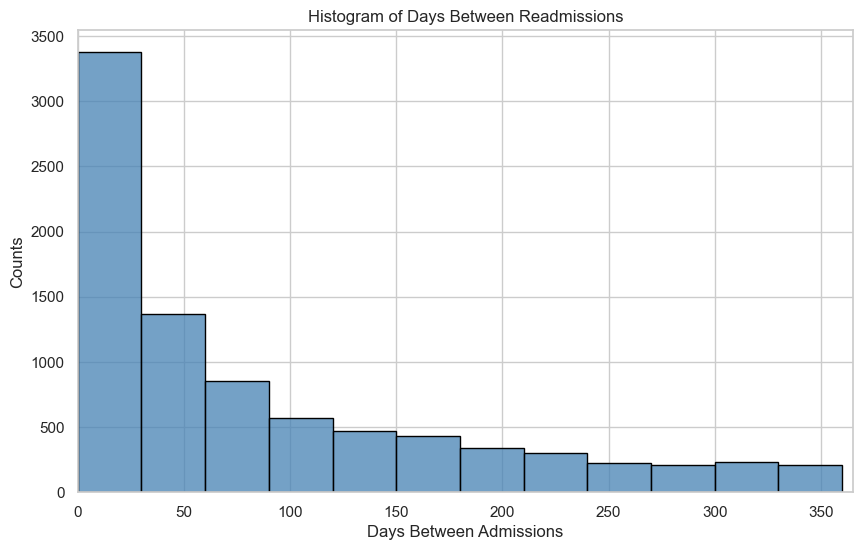

In [25]:

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis with a specific size
plt.figure(figsize=(10, 6))

# Plot the histogram using Seaborn
sns.histplot(data=df_adm2.loc[~df_adm2.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins=range(0, 365, 30), kde=False, color='steelblue', edgecolor='black')

# Set plot title and labels
plt.title('Histogram of Days Between Readmissions')
plt.xlabel('Days Between Admissions')
plt.ylabel('Counts')

# Set x-axis and y-axis limits
plt.xlim([0, 365])

# Show plot
plt.show()

In [26]:
df_notes = pd.read_csv("NOTEEVENTS.csv.gz")


C:\Users\T\AppData\Local\Temp\ipykernel_4904\2246050120.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv("NOTEEVENTS.csv.gz")


In [ ]:
df_notes.head()


In [28]:
df_notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB


In [29]:
use_cols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'TEXT']


In [30]:
df_notes = pd.read_csv("NOTEEVENTS.csv.gz",usecols= use_cols, low_memory = False, engine = "c")


In [31]:
print('Number of Notes: {}'.format(len(df_notes)))

Number of Notes: 2083180


In [32]:
df_notes.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [33]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [34]:
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [36]:
case_36 = df_notes.loc[df_notes.SUBJECT_ID == 36,['SUBJECT_ID','HADM_ID','CATEGORY','TEXT']]

In [37]:
case_36.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Radiology', 'Nursing/other'],
      dtype=object)

In [38]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [39]:
df_notes_dis_sum.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [40]:
df_notes_dis_sum.duplicated(['HADM_ID']).sum()

6926

We've identified 6921 repeated discharge summaries, as evidenced by the following code. To ensure a smooth merger of the two datasets, it's essential that we first remove these duplicates.

assert ..., ""

In [41]:
assert df_notes_dis_sum.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'


#if df_notes_dis_sum.duplicated(['HADM_ID']).sum() != 0:
    #raise AssertionError('Multiple discharge summaries per admission')

AssertionError: Multiple discharge summaries per admission

In [42]:
df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...
...,...,...,...,...
60411,93924,135672.0,Discharge summary,"Name: [**Known lastname 18321**],[**Known fir..."
60412,17782,155710.0,Discharge summary,"Name: [**Known lastname 2706**], [**Known fir..."
60413,96333,183951.0,Discharge summary,Name: [**Known lastname 18357**]-[**Known las...
60414,66717,169165.0,Discharge summary,"Name: [**Known lastname **],[**Known firstnam..."


In [45]:
#for simplicity we just save the last discharge note and remove the rest.
# (we could also concatenate all the notes)

df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()


In [ ]:
# we try the assert below and it shows that there are no duplicates
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

In [47]:
#here we can look at the discharge note for subject_id 1370
subject_id = 13702
subject_data = df_notes_dis_sum_last[df_notes_dis_sum_last['SUBJECT_ID'] == subject_id]
subject_data.TEXT[0]

'Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]\n\nDate of Birth:                    Sex:  F\n\nService:  MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS:  This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare.  Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%.  She has also been on\nlevofloxacin and nebulizers, and was not getting better, and\npresented to the [**Hospital1 18**] Emergency Room.\n\nIn the [**Hospital3 **] Emergency Room, her oxygen saturation was\n100% on CPAP.  She was not able to be weaned off of this\ndespite nebulizer treatment and Solu-Medrol 125 mg IV x2.\n\nReview of systems is negative for the following:  Fevers,\nchills, nausea, vomiting, nigh

In [49]:
# number of rows in 2 datasets are equal.
assert len(df_adm2) == len(df_adm_notes), 'Number of rows increased'

next step : We merge the 2 datasets " df_adm2 " and  "df_notes_dis_sum_last" into a single dataset.

In [48]:
df_adm_notes = pd.merge(df_adm2[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')


In [ ]:
df_adm_notes.head()

In [51]:
df_adm_notes.info()

#  We observe a total of 58976 entries, out of which 52726 contain text. 
# This indicates that certain entries are lacking text content.   


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SUBJECT_ID       58976 non-null  int64         
 1   HADM_ID          58976 non-null  int64         
 2   ADMITTIME        58976 non-null  datetime64[ns]
 3   DISCHTIME        58976 non-null  datetime64[ns]
 4   DAYS_NEXT_ADMIT  12456 non-null  float64       
 5   NEXT_ADMITTIME   12456 non-null  datetime64[ns]
 6   ADMISSION_TYPE   58976 non-null  object        
 7   DEATHTIME        5854 non-null   datetime64[ns]
 8   TEXT             52726 non-null  object        
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Check to see if there are alot of notes that are missing text (might be a sign of a problem).

In [53]:
df_adm_notes.TEXT.isnull().sum()
df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes) * 100

# Around 6250 entries, which constitutes approximately 10% of the total, lack text content.

10.59753119913185

In [47]:
df_adm_notes.TEXT.str.contains('\n').sum()

52726

In [ ]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes)*100)
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes)*100)
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes)*100)

Fraction of missing notes: 10.59753119913185
Fraction notes with newlines: 89.40246880086815
Fraction notes with carriage returns: 0.0


The follwing code computes the percentage of missing values in the 'TEXT' column for every distinct admission type. 
In this process we grouped the DataFrame by the 'ADMISSION_TYPE' column.
We also used the lambda function to determine the total count of absent 'TEXT' values within each grouping. This total is divided by the overall row count for each admission type, generating a Series.

In [56]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()*100

ADMISSION_TYPE
ELECTIVE      4.866338
EMERGENCY     3.798341
NEWBORN      53.669083
URGENT        4.266467
dtype: float64

Roughly half of the entries with the 'NEWBORN' admission type are absent, and our preference is to exclude them.

In [58]:

df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [60]:
df_adm_notes_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51113 entries, 1 to 58975
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   SUBJECT_ID       51113 non-null  int64         
 1   HADM_ID          51113 non-null  int64         
 2   ADMITTIME        51113 non-null  datetime64[ns]
 3   DISCHTIME        51113 non-null  datetime64[ns]
 4   DAYS_NEXT_ADMIT  12225 non-null  float64       
 5   NEXT_ADMITTIME   12225 non-null  datetime64[ns]
 6   ADMISSION_TYPE   51113 non-null  object        
 7   DEATHTIME        5792 non-null   datetime64[ns]
 8   TEXT             49083 non-null  object        
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [ ]:
# Calculate the fraction of missing notes
missing_notes_fraction = df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean)
print('Fraction of missing notes:', "{:.2%}".format(missing_notes_fraction))

# Calculate the fraction of notes with newlines
newlines_fraction = df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean)
print('Fraction notes with newlines:', "{:.2%}".format(newlines_fraction))

# Calculate the fraction of notes with carriage returns
carriage_returns_fraction = df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean)
print('Fraction notes with carriage returns:', "{:.2%}".format(carriage_returns_fraction))

Fraction of missing notes: 3.97%
Fraction notes with newlines: 96.03%
Fraction notes with carriage returns: 0.00%


Upon eliminating newborn entries, it becomes evident that our proportion of absent notes
 has reduced from around 10% to approximately 4%.

I want to make a new column in the dataframe called OUTPUT_LABEL, which will show whether the patient was re-admitted within 30 days.

In [61]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [62]:
df_adm_notes_clean['OUTPUT_LABEL']

1        0
2        0
4        0
7        0
9        0
        ..
58971    0
58972    0
58973    0
58974    0
58975    0
Name: OUTPUT_LABEL, Length: 51113, dtype: int32

In the codes below, positive samples refer to patients with readmission within 30 days, 
while negative samples correspond to entries without readmissions within 30 days.
we observe that 3166 entries (6% of total entries) experienced readmission within 30 days of discharge.

In [63]:
print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

num_positive_samples = (df_adm_notes_clean.OUTPUT_LABEL == 1).sum()
num_negative_samples = (df_adm_notes_clean.OUTPUT_LABEL == 0).sum()
total_samples = len(df_adm_notes_clean)

Number of positive samples: 3166
Number of negative samples: 47947
Total samples: 51113


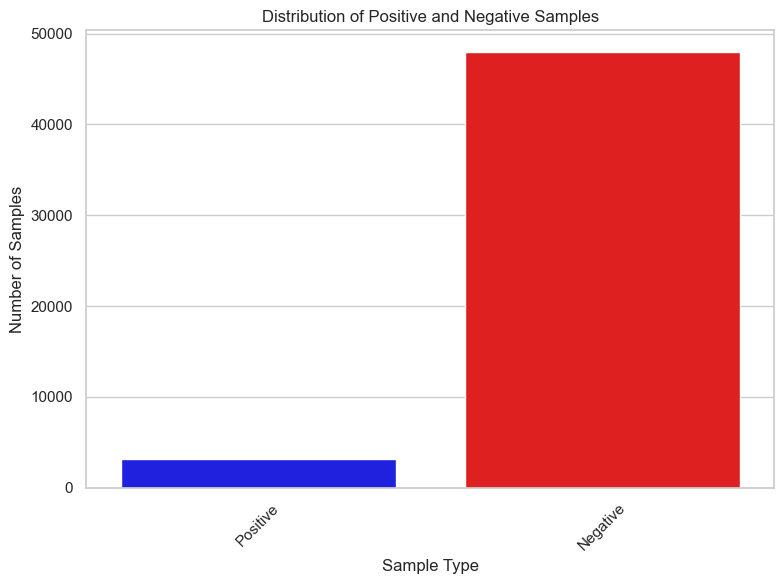

Total samples: 51113


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['Positive', 'Negative'], y=[num_positive_samples, num_negative_samples], palette=['blue', 'red'])
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.title('Distribution of Positive and Negative Samples')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Print total samples
print('Total samples:', total_samples)

In [65]:
# Calculate the percentages
percentage_positive = (num_positive_samples / total_samples) * 100
percentage_negative = (num_negative_samples / total_samples) * 100

# Print the percentages
print('Percentage of Positive Samples:', "{:.2f}%".format(percentage_positive))
print('Percentage of Negative Samples:', "{:.2f}%".format(percentage_negative))
print('Total samples:', total_samples)

Percentage of Positive Samples: 6.19%
Percentage of Negative Samples: 93.81%
Total samples: 51113


## Create training and test dataframes

When we build a predictive model, we want the model to work well on data that the model has never seen. To test for this, we take our data and split it into three datasets: training, validation, and test.

- **Training set:** Used to train the model.
- **Validation set:** Data the model didn't see, but is used to optimize or tune the model.
- **Test set:** This data, unfamiliar to the model and the tuning process, acts as a genuine assessment of  the model's ability to predict.



In [66]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667): 0.06456241032998565
Valid prevalence(n = 7667): 0.061171253423764185
Train all prevalence(n = 35779): 0.061544481399703733
all samples (n = 51113)


Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options
- balance the data by sub-sampling the negatives
- balance the data by over-sampling the positives
- create synthetic data (e.g. SMOTE)

In this example, we will sub-sample the negatives

In [63]:
# Under-sampling:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = {}): {}%'.format(len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train)*100))

Train prevalence (n = 4184): 50.0%


# Step 2: Preprocess text data
Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

BOW basically breaks up the note into the individual words and counts how many times each word occurs. Your numerical data then becomes counts for some set of words as shown below. BOW is the simplest way to do NLP classification. In most blog posts I have read, fancier techniques have a hard time beating BOW for NLP classification tasks.

In this process, there are few choices that need to be made
- how to pre-process the words
- how to count the words
- which words to use

There is no optimal choice for all NLP projects, so I recommend trying out a few options when building your own models.

You can do the pre-processing in two ways:
- modify the original dataframe TEXT column
- pre-process as part of your pipeline so you don't edit the original data (allows you try out a few options easily)

### Preprocess all the notes
Modify the original dataframe by dealing with the missing text, newlines and carriage returns

In [64]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [65]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

### Build a tokenizer
Now we need to create a function that splits the note into individual words. This function is called a tokenizer. We can use the nltk.word_tokenize function to this for us.

In [66]:
import nltk
from nltk import word_tokenize
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '02/02/2018',
 'sentence',
 'has',
 'stars',
 '*',
 '*']

Note that some punctuation is separated but not all punctuation.
We can define our own custom tokenizer. Our tokenizer will
- replace punctuation with spaces
- remove numbers with spaces
- lowercase all words

I like to do these steps as part of the tokenizer, so I can go back and look at the original note. The new line and carriage return is more difficult to deal with so I did it in the preprocessing step above.

In [67]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [68]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words

    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

Testing the function on the previous text example

In [69]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

### Build a simple vectorizer
Now that we have a way to convert free-text into tokens, we need a way to create features from these tokens.

In [70]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

c:\Users\T\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [79]:
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [80]:
# we can visualize this small example if we convert it to an array
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int64)

In [86]:
# Retrieve the vocabulary (feature names) from the CountVectorizer instance
feature_names = vect.get_feature_names_out()
print(feature_names)

['about' 'amazing' 'data' 'is' 'modeling' 'of' 'part' 'predictive'
 'science' 'the']


## build a vectorizer on the clinical notes

In [87]:
# from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(df_train.TEXT.values)

c:\Users\T\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=3000,
                tokenizer=<function tokenizer_better at 0x000001FEB844ADE0>)

# Zipf's law

In [ ]:
# Transform text data for negative class samples
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)

# Transform text data for positive class samples
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)

# Compute term frequency for negative class documents
neg_tf = np.sum(neg_doc_matrix, axis=0)

# Compute term frequency for positive class documents
pos_tf = np.sum(pos_doc_matrix, axis=0)

# Convert term frequency matrices to 1D arrays
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

# Create a DataFrame to store term frequency information
term_freq_df = pd.DataFrame([neg, pos], columns=vect.get_feature_names_out()).transpose()
term_freq_df.columns = ['negative', 'positive']

# Add a 'total' column representing the sum of negative and positive counts
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']

# Sort the DataFrame by total counts in descending order and retrieve the top 10 terms
top_terms = term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

# # Create a bar plot for the top terms' counts
# ax = top_terms['total'].plot(kind='bar', figsize=(10, 6), width=0.8, fontsize=14, rot=90, color='b')
# ax.title.set_size(18)
# plt.ylabel('count')
# plt.show()

# # Create a Series from the total term frequencies and sort it in descending order
# d = pd.Series(term_freq_df.total, index=term_freq_df.index).sort_values(ascending=False)

# # Create a bar plot for the top 50-100 terms' counts
# ax = d[50:100].plot(kind='bar', figsize=(10, 6), width=0.8, fontsize=14, rot=90, color='b')
# ax.title.set_size(18)
# plt.ylabel('count')
# plt.show()

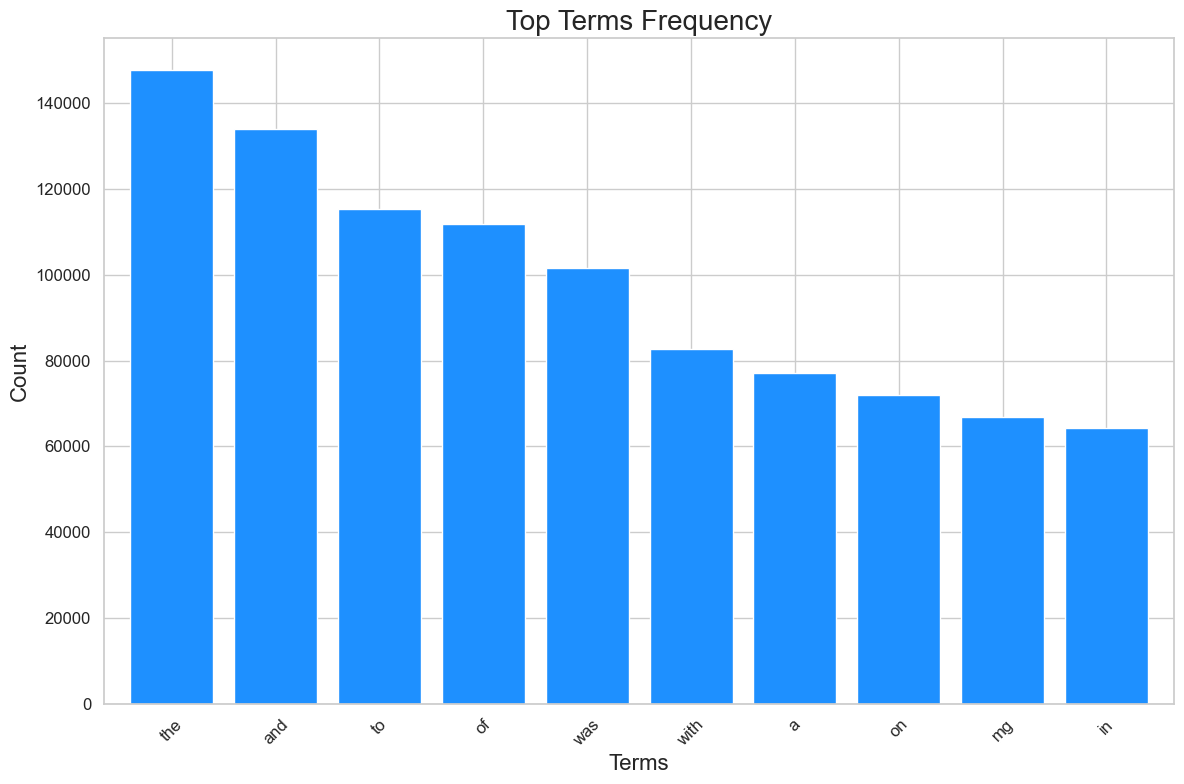

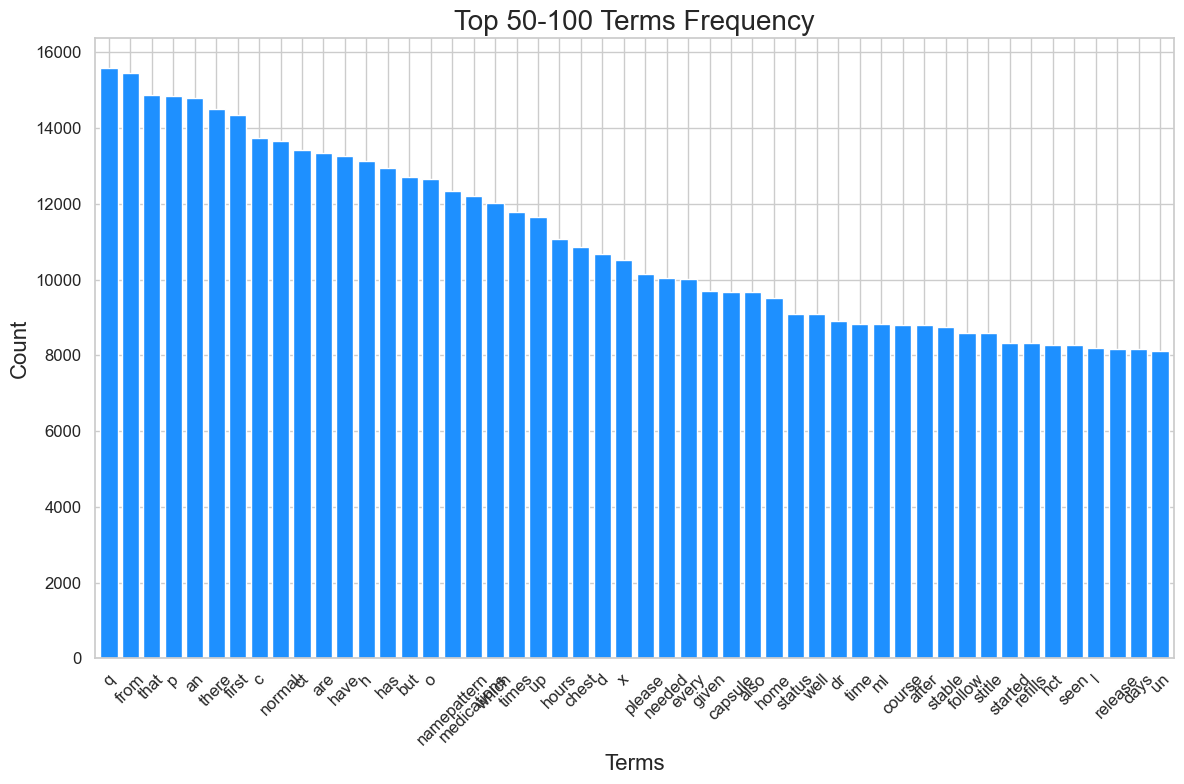

In [89]:
# Set a more visually pleasing style for the plots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))  # Set a larger figure size

# Create a bar plot for the top terms' counts
ax = top_terms['total'].plot(kind='bar', color='dodgerblue', width=0.8)
ax.set_title('Top Terms Frequency', fontsize=20)
ax.set_xlabel('Terms', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(axis='x', labelrotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Set a larger figure size again for the second plot
plt.figure(figsize=(12, 8))

# Create a bar plot for the top 50-100 terms' counts
ax = d[50:100].plot(kind='bar', color='dodgerblue', width=0.8)
ax.set_title('Top 50-100 Terms Frequency', fontsize=20)
ax.set_xlabel('Terms', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.tick_params(axis='x', labelrotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Adding stopwords

In [96]:
from nltk.corpus import stopwords

# Load the English stop words list
stop_words = stopwords.words('english')

In [97]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Using vectorizer while removing the stopwords from text

In [102]:
vect = CountVectorizer(max_features = 3000,
                       tokenizer = tokenizer_better,
                       stop_words = stop_words
                       )
# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(max_features=3000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenizer_better at 0x000001FEB844ADE0>)

Transform notes into the vector format

In [103]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

Get labels

In [106]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL